In [1]:
import manify

In [2]:
pm = manify.ProductManifold(signature=[(1, 2), (0, 2), (-1, 2)])

X, y = pm.gaussian_mixture(1000)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pdt = manify.ProductSpaceDT(pm=pm, n_features="d_choose_2", max_depth=4)
pdt.fit(X_train, y_train)

print(f"{pdt.score(X_test, y_test).float().mean().item():.4f}")

0.8550


In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(X[:, 9].numpy(), X[:, 11].numpy(), c=y)

# plot decision boundary
theta = 2.141489028930664
c = np.cos(theta)
s = np.sin(theta)
plt.plot([-s * 1e10, s * 1e10], [-c * 1e10, c * 1e10], "r-")

# put boundaries back
plt.xlim(X[:, 9].min(), X[:, 9].max())
plt.ylim(X[:, 11].min(), X[:, 11].max())

IndexError: index 9 is out of bounds for dimension 1 with size 8

In [5]:
# This code will traverse the decision tree level by level and do the following:
# 1. Store a mask for whether data points are "live" or not, i.e. whether they were thrown out in previous levels
# 2. Get projection dimensions (pdt.angle_dims[feature])
# 3. Get the threshold
# 4. Store the (mask, dim1, dim2, threshold) tuple in a list
import torch
from manify.predictors.decision_tree import _angular_greater
import matplotlib.pyplot as plt

angles, _, _, comparisons = pdt._preprocess(X, y)

levels = []
to_visit = [(pdt.nodes[0], torch.ones(X.shape[0]).bool())]
while to_visit:
    levels.append(to_visit)
    new_to_visit = []
    l = [
        (node.left, mask & _angular_greater(angles[:, node.feature], torch.tensor(node.theta)).flatten())
        for node, mask in to_visit
        if node.left is not None
    ]
    r = [
        (node.right, mask & ~_angular_greater(angles[:, node.feature], torch.tensor(node.theta)).flatten())
        for node, mask in to_visit
        if node.right is not None
    ]
    to_visit = l + r

print([len(l) for l in levels])

[1, 2, 4, 8, 10]


/tmp/ipykernel_90552/3991220016.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  axs[i, j].scatter(X[mask, dim1].numpy(), X[mask, dim2].numpy(), c=y[mask], cmap=plt.cm.get_cmap("coolwarm"))
/tmp/ipykernel_90552/3991220016.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax_single.scatter(X[mask, dim1].numpy(), X[mask, dim2].numpy(), c=y[mask], cmap=plt.cm.get_cmap("coolwarm"))
/tmp/ipykernel_90552/3991220016.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  axs[i, j

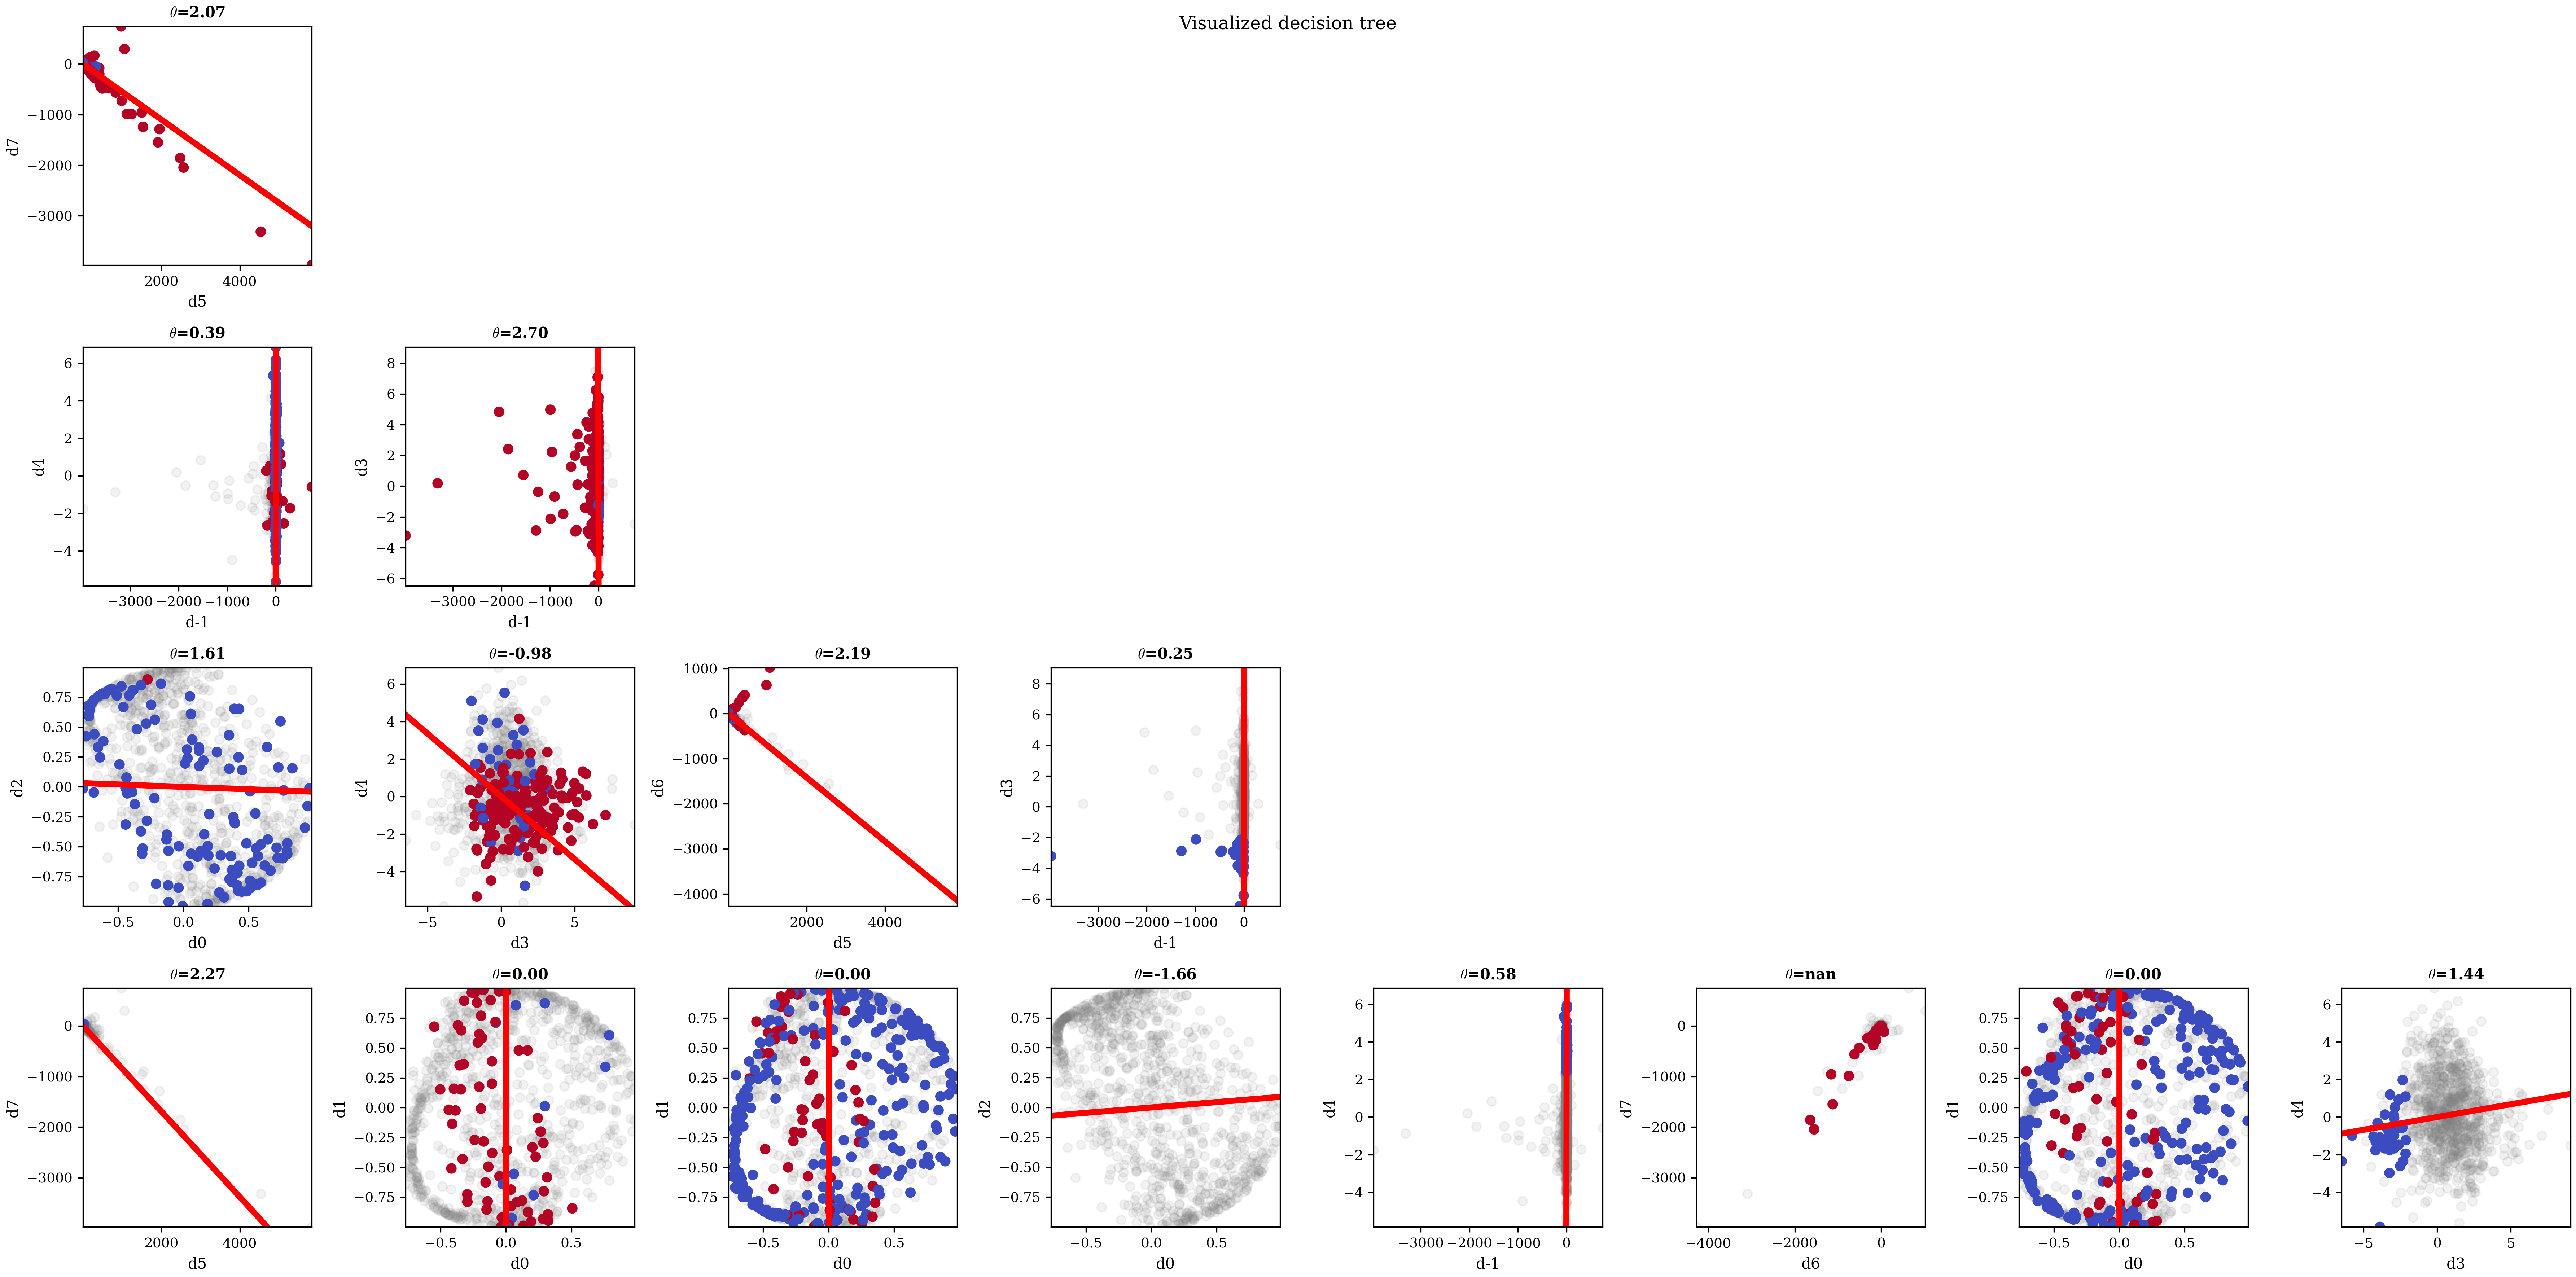

In [12]:
# Load the custom style
plt.style.use("./icml.mplstyle")

# Define colors
color1 = "#5727b0"
color2 = "#b02780"

# Create directory for saving subplots
import os

os.makedirs("tree_visualized", exist_ok=True)

rows = len(levels) - 1  # Since final levels are homogeneous
cols = max(len(l) for l in levels[:-1])
fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

for i, level in enumerate(levels[:-1]):
    for j in range(cols):
        if j >= len(level):
            axs[i, j].axis("off")
            continue
        node, mask = level[j]

        if node.feature is None:
            continue

        # Plot points
        dim1, dim2 = pdt.angle_dims[node.feature]
        if dim1 is not None:
            axs[i, j].scatter(X[~mask, dim1].numpy(), X[~mask, dim2].numpy(), c="grey", alpha=0.1)
            axs[i, j].scatter(X[mask, dim1].numpy(), X[mask, dim2].numpy(), c=y[mask], cmap=plt.cm.get_cmap("coolwarm"))
        else:
            axs[i, j].scatter(np.ones((~mask).sum()), X[~mask, dim2].numpy(), c="grey", alpha=0.1)
            axs[i, j].scatter(np.ones(mask.sum()), X[mask, dim2].numpy(), c=y[mask], cmap=plt.cm.get_cmap("coolwarm"))

        # Plot line
        c = np.cos(node.theta)
        s = np.sin(node.theta)
        axs[i, j].plot([-s * 1e10, s * 1e10], [-c * 1e10, c * 1e10], "r-", linewidth=4)

        # Put boundaries back
        axs[i, j].set_xlim(X[:, dim1].min(), X[:, dim1].max())
        axs[i, j].set_ylim(X[:, dim2].min(), X[:, dim2].max())

        # Title is split
        axs[i, j].set_title(f"$\\theta$={node.theta:.2f}")
        axs[i, j].set_xlabel(f"d{dim1}")
        axs[i, j].set_ylabel(f"d{dim2}")
        axs[i, j].spines["top"].set_visible(True)
        axs[i, j].spines["right"].set_visible(True)

        # Save each subplot as a separate PDF
        fig_single, ax_single = plt.subplots(figsize=(3, 3))
        ax_single.spines["top"].set_visible(True)
        ax_single.spines["right"].set_visible(True)
        ax_single.set_xticklabels([])
        ax_single.set_yticklabels([])
        ax_single.set_xlabel(f"d{dim1}")
        ax_single.set_ylabel(f"d{dim2}")
        ax_single.scatter(X[~mask, dim1].numpy(), X[~mask, dim2].numpy(), c="grey", alpha=0.1)
        ax_single.scatter(X[mask, dim1].numpy(), X[mask, dim2].numpy(), c=y[mask], cmap=plt.cm.get_cmap("coolwarm"))
        ax_single.plot([-s * 1e10, s * 1e10], [-c * 1e10, c * 1e10], "r-")
        ax_single.set_xlim(X[:, dim1].min(), X[:, dim1].max())
        ax_single.set_ylim(X[:, dim2].min(), X[:, dim2].max())
        ax_single.set_title(f"({dim1}, {dim2}), $\\theta$={node.theta:.2f}")
        fig_single.tight_layout()
        fig_single.savefig(f"tree_visualized/level_{i}_node_{j}.pdf")
        plt.close(fig_single)

plt.tight_layout()
plt.suptitle("Visualized decision tree")
plt.savefig("decision_tree_visualization.pdf")